# Notebook 5 - Property modeling with conventional molecular descriptors

By Vincent Blay, Tijana Radivojevic November 2021 - May 2022

This notebook was developed using **RPReactor 3.8** kernel on [jprime.lbl.gov](https://gpu2.ese.lbl.gov/).

This notebooks illustrates the use of conventional molecular descriptors from rdkit to model different molecular properties in this work.

In [1]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

%run "./plotting.py"

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
def smiles_to_descriptors(smiles):
    smiles = list(smiles)
    names = [x[0] for x in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)

    idx = []
    D = []
    for i in range(len(smiles)):
        smi = smiles[i]
        mol = MolFromSmiles(smi)
        if mol is not None:
            descriptors = calc.CalcDescriptors(mol)
            D.append(descriptors)
            idx.append(i)

    D = pd.to_numeric(D, errors='coerce') # converts any string to nan

    # Let us now remove columns with any nan value
    D = pd.DataFrame(D)
    D.columns = names
    D[abs(D) > 1e5] = np.nan
    D.dropna(axis=1, how='any', inplace=True)
    
    # Let us also remove columns with very small standard deviation
    sd = D.std(axis=1)
    D.drop(np.where(sd<0.001)[0],axis=1)
    
    return D, idx

## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [4]:
df = pd.read_csv("./data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


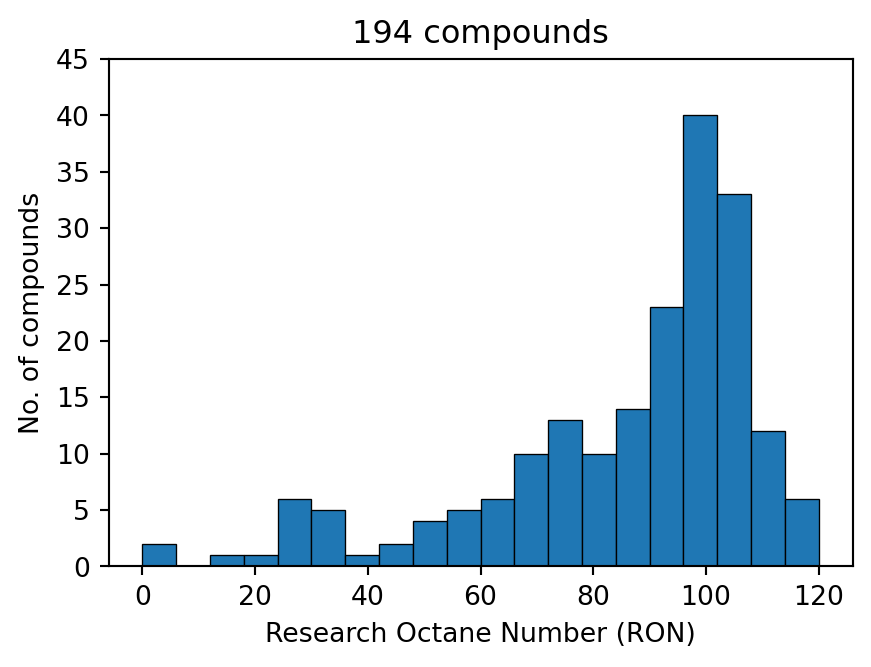

In [5]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us now compute the molecular descriptors:

In [6]:
D, idx = smiles_to_descriptors(smiles)
Y = Y[idx]

In [7]:
D.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2.1875,0.369792,2.1875,0.369792,0.408425,98.189,84.077,98.10955,42,0,...,0,0,0,0,0,0,0,0,0,0
1,2.253472,0.852963,2.253472,0.852963,0.492217,112.216,96.088,112.125201,48,0,...,0,0,0,0,0,0,0,0,0,0
2,10.243056,0.453704,10.243056,0.453704,0.42968,84.118,76.054,84.057515,34,0,...,0,0,0,0,0,0,0,0,0,0
3,1.5,1.5,1.5,1.5,0.408362,70.135,60.055,70.07825,30,0,...,0,0,0,0,0,0,0,0,0,0
4,1.5,1.5,1.5,1.5,0.422316,84.162,72.066,84.0939,36,0,...,0,0,0,0,0,0,0,0,0,0


Define the partitions for cross-validation.

In [4]:
num_of_partitions = 10
kf = KFold(n_splits=num_of_partitions, shuffle=True, random_state=42)

We want to select a subset of descriptors that we will use to train the model.

In [5]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=15)


Define hyperparameters for the regression model:

In [10]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

In [11]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D.iloc[train_index, :], D.iloc[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Select those descriptors that we will use to train the model
    sfs.fit(D_train, y_train)
    print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}\n")
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
Features selected by forward sequential selection: ['HeavyAtomMolWt', 'BertzCT', 'Chi1n', 'Chi3n', 'HallKierAlpha', 'PEOE_VSA5', 'PEOE_VSA6', 'SMR_VSA4', 'EState_VSA5', 'EState_VSA7', 'VSA_EState5', 'VSA_EState7', 'VSA_EState9', 'NumRotatableBonds', 'fr_unbrch_alkane']

{'C': 50, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 2/10
Features selected by forward sequential selection: ['MaxPartialCharge', 'Chi2n', 'PEOE_VSA2', 'SMR_VSA4', 'SMR_VSA6', 'SlogP_VSA4', 'EState_VSA2', 'EState_VSA4', 'VSA_EState1', 'VSA_EState5', 'VSA_EState7', 'NHOHCount', 'NumRotatableBonds', 'MolLogP', 'fr_unbrch_alkane']

{'C': 100, 'epsilon': 5, 'kernel': 'rbf'}
Partition 3/10
Features selected by forward sequential selection: ['MaxPartialCharge', 'BCUT2D_CHGLO', 'Chi2n', 'PEOE_VSA2', 'PEOE_VSA5', 'PEOE_VSA6', 'SMR_VSA4', 'SlogP_VSA4', 'EState_VSA2', 'EState_VSA4', 'VSA_EState5', 'VSA_EState7', 'fr_bicyclic', 'fr_ketone', 'fr_unbrch_alkane']

{'C': 500, 'epsilon': 5, 'kernel': 'rbf'}
Partition 4/1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


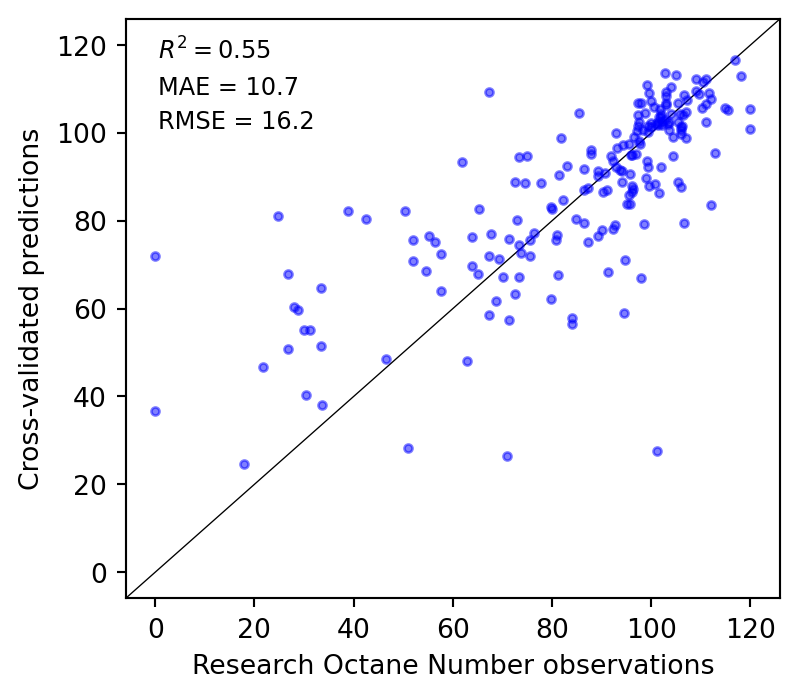

In [12]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Research Octane Number observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/rdkit/rdkit_RON.svg') 

## Cetane Number (CN)

In [13]:
df = pd.read_csv("./data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


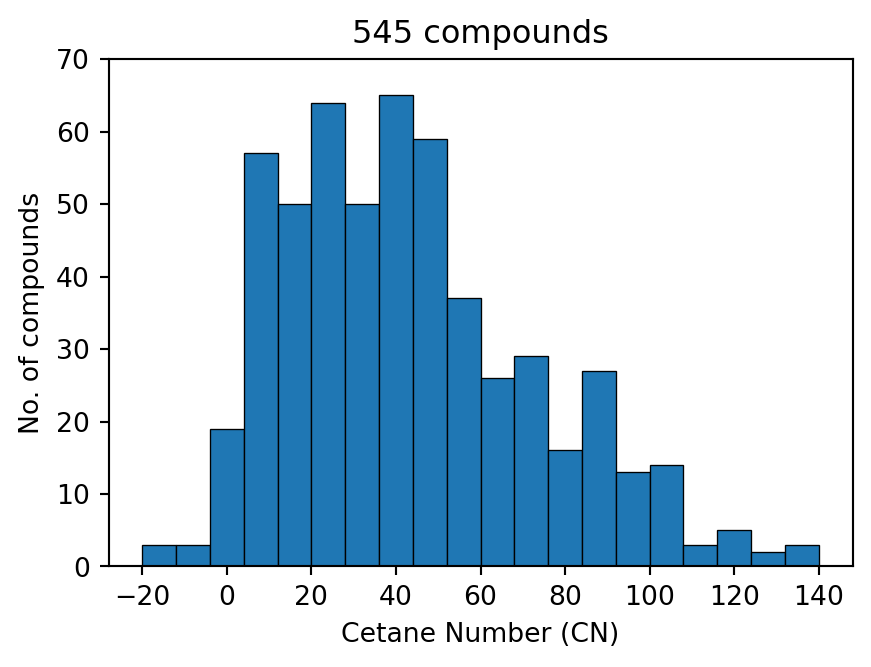

In [14]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [15]:
D, idx = smiles_to_descriptors(smiles)
Y = Y[idx]

In [16]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D.iloc[train_index, :], D.iloc[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Select those descriptors that we will use to train the model
    sfs.fit(D_train, y_train)
    print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}\n")
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
Features selected by forward sequential selection: ['MaxEStateIndex', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BertzCT', 'PEOE_VSA10', 'TPSA', 'EState_VSA1', 'VSA_EState1', 'FractionCSP3', 'NumAliphaticHeterocycles', 'NumHAcceptors', 'NumSaturatedCarbocycles', 'fr_Ar_OH', 'fr_aryl_methyl', 'fr_unbrch_alkane']

{'C': 500, 'epsilon': 1, 'kernel': 'rbf'}
Partition 2/10
Features selected by forward sequential selection: ['MaxEStateIndex', 'MinEStateIndex', 'qed', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA9', 'SlogP_VSA6', 'SlogP_VSA8', 'EState_VSA1', 'EState_VSA9', 'NumAliphaticHeterocycles', 'fr_Al_OH', 'fr_aryl_methyl', 'fr_ether', 'fr_unbrch_alkane']

{'C': 500, 'epsilon': 5, 'kernel': 'rbf'}
Partition 3/10
Features selected by forward sequential selection: ['MaxEStateIndex', 'FpDensityMorgan1', 'FpDensityMorgan3', 'BCUT2D_MRHI', 'HallKierAlpha', 'PEOE_VSA2', 'SMR_VSA6', 'SlogP_VSA6', 'NumSaturatedRings', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_aryl_methyl', 'fr_bicyclic', 'fr_m

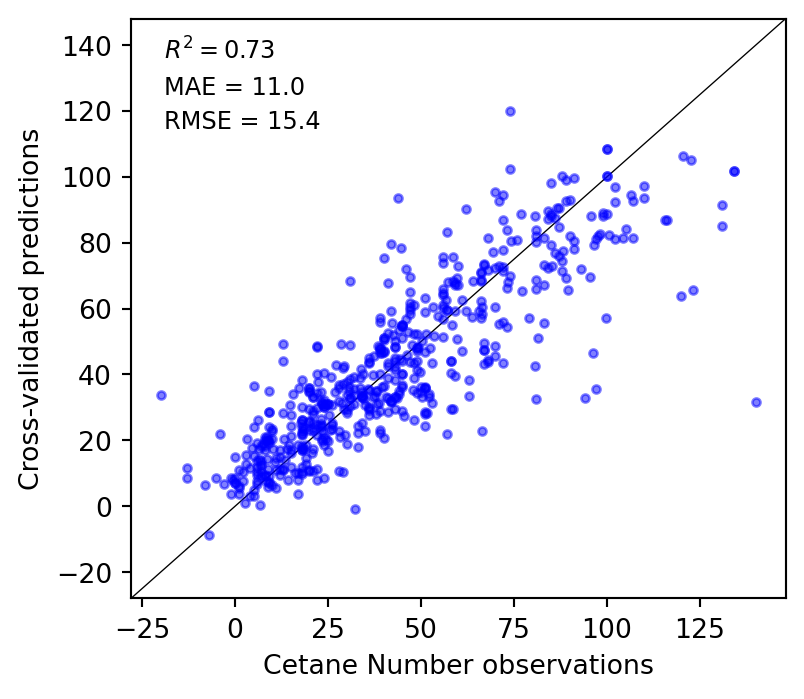

In [17]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/rdkit/rdkit_CN.svg') 

##  Melting Point (MP)

In [6]:
df = pd.read_csv("./data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


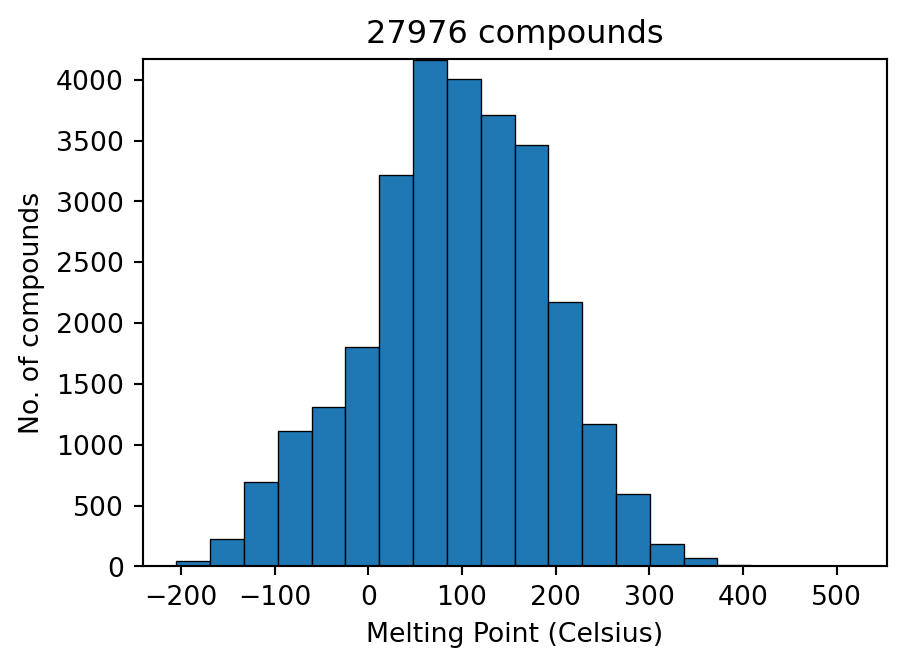

In [7]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [8]:
%%capture
D, idx = smiles_to_descriptors(list(smiles))
Y = Y[idx]

In [9]:
param_grid = {
    'C': [100, 300, 500], 
    'epsilon': [3, 5, 10, 20],
    'kernel': ['rbf']
}

In [10]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D.iloc[train_index, :], D.iloc[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # This dataset is too big to use the SequentialFeatureSelector directly. 
    # Let us downsample it for the feature selection step:
    idx = np.random.choice(range(len(D_train)), size=3000, replace=False)
    D_train_downsampled = D_train.iloc[idx]
    y_train_downsampled = y_train.iloc[idx]
    
    # Select those descriptors that we will use to train the model
    sfs = SequentialFeatureSelector(
        LinearRegression(), n_features_to_select=15, cv=5, n_jobs=5
    )
    sfs.fit(D_train_downsampled, y_train_downsampled)
    print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}\n")
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
Features selected by forward sequential selection: ['MaxEStateIndex', 'qed', 'FpDensityMorgan2', 'BalabanJ', 'BertzCT', 'SMR_VSA10', 'TPSA', 'EState_VSA1', 'EState_VSA5', 'FractionCSP3', 'NumAliphaticRings', 'NumHDonors', 'RingCount', 'fr_Ar_N', 'fr_COO2']

{'C': 500, 'epsilon': 3, 'kernel': 'rbf'}
Partition 2/10
Features selected by forward sequential selection: ['MinAbsEStateIndex', 'qed', 'BalabanJ', 'BertzCT', 'HallKierAlpha', 'SMR_VSA10', 'EState_VSA8', 'FractionCSP3', 'NHOHCount', 'NumAliphaticRings', 'NumRotatableBonds', 'fr_Ar_COO', 'fr_Ar_N', 'fr_aniline', 'fr_unbrch_alkane']

{'C': 500, 'epsilon': 5, 'kernel': 'rbf'}
Partition 3/10
Features selected by forward sequential selection: ['MinAbsEStateIndex', 'qed', 'FpDensityMorgan1', 'BertzCT', 'HallKierAlpha', 'SMR_VSA10', 'SMR_VSA3', 'SlogP_VSA4', 'FractionCSP3', 'NHOHCount', 'NumAliphaticRings', 'NumAromaticHeterocycles', 'fr_ArN', 'fr_COO', 'fr_bicyclic']

{'C': 500, 'epsilon': 3, 'kernel': 'rbf'}
Partition 4/1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


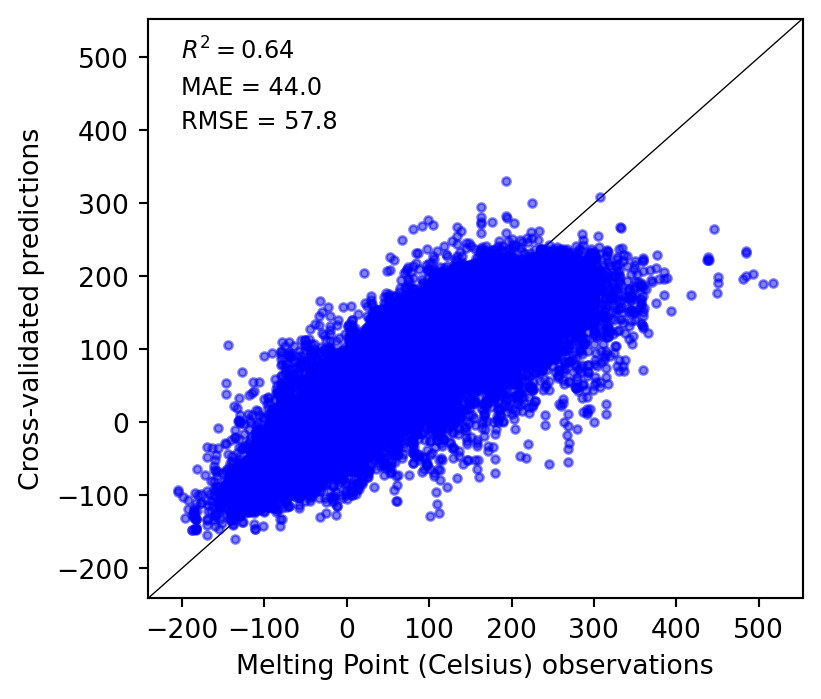

In [11]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Melting Point (Celsius) observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/rdkit/rdkit_MP.svg') 

## Flash Point (FP)

In [18]:
df = pd.read_csv("./data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


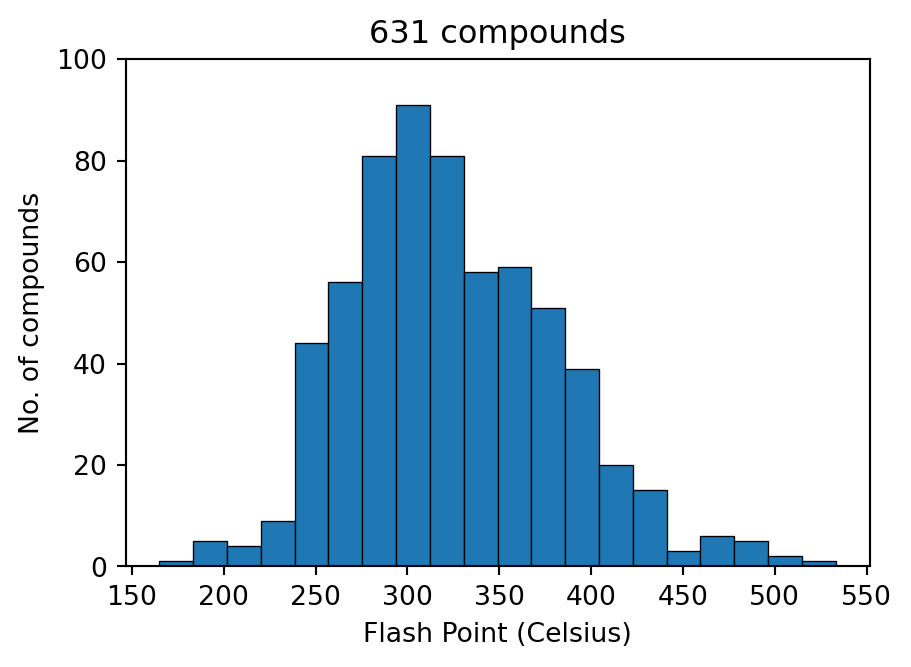

In [19]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [20]:
D, idx = smiles_to_descriptors(smiles)
Y = Y[idx]

In [21]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

In [22]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=15)

In [23]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D.iloc[train_index, :], D.iloc[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Select those descriptors that we will use to train the model
    sfs.fit(D_train, y_train)
    print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}\n")
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
Features selected by forward sequential selection: ['qed', 'HeavyAtomMolWt', 'FpDensityMorgan3', 'BCUT2D_MRLOW', 'BertzCT', 'Kappa1', 'PEOE_VSA2', 'PEOE_VSA7', 'SMR_VSA5', 'SMR_VSA9', 'VSA_EState3', 'VSA_EState4', 'NumAromaticCarbocycles', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles']

{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 2/10
Features selected by forward sequential selection: ['HeavyAtomMolWt', 'BCUT2D_MRLOW', 'BertzCT', 'Chi4n', 'Kappa1', 'PEOE_VSA2', 'PEOE_VSA7', 'SMR_VSA5', 'SMR_VSA9', 'EState_VSA2', 'VSA_EState3', 'VSA_EState4', 'NumAliphaticHeterocycles', 'NumAromaticRings', 'NumSaturatedCarbocycles']

{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 3/10
Features selected by forward sequential selection: ['HeavyAtomMolWt', 'FpDensityMorgan1', 'FpDensityMorgan3', 'BCUT2D_MRLOW', 'BertzCT', 'PEOE_VSA7', 'SMR_VSA6', 'VSA_EState3', 'VSA_EState4', 'NumAliphaticHeterocycles', 'NumAromaticRings', 'fr_Al_OH_noTert', 'fr_aryl_methyl', 'fr_bicyc

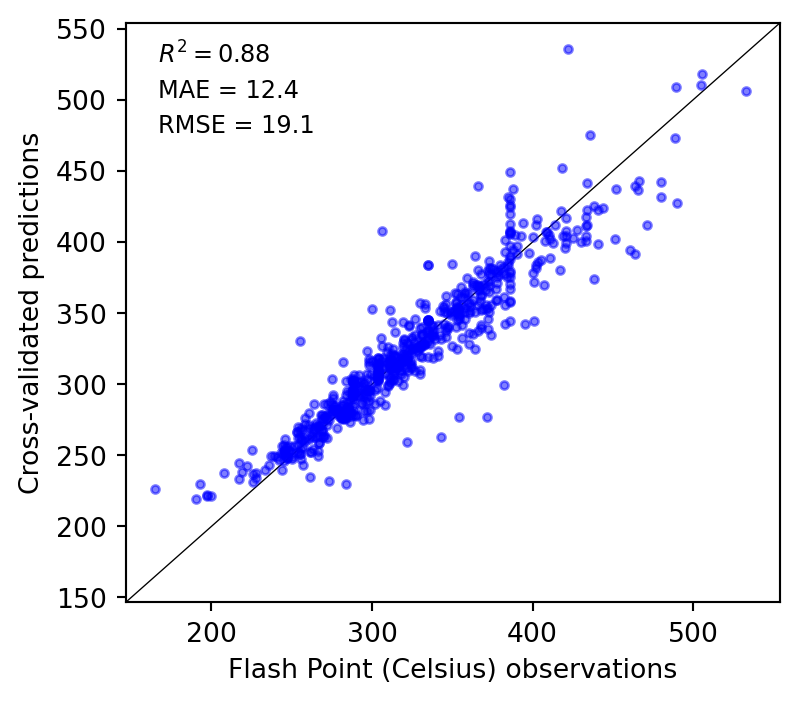

In [24]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Flash Point (Celsius) observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/rdkit/rdkit_FP.svg') 

## Histamine receptor pKi

In [25]:
df = pd.read_csv("./data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1214


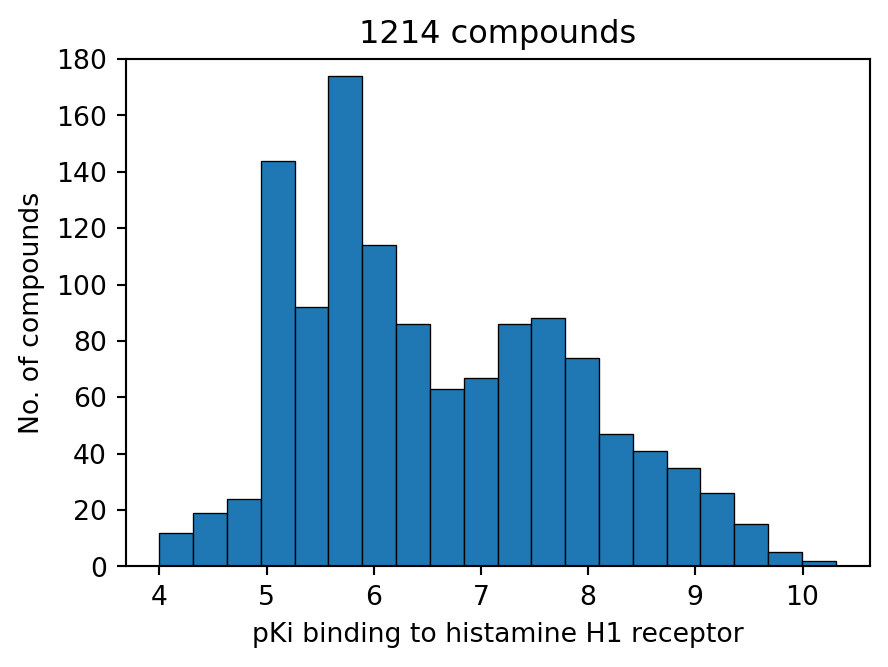

In [26]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [27]:
D, idx = smiles_to_descriptors(smiles)
Y = Y[idx]

In [28]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D.iloc[train_index, :], D.iloc[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Select those descriptors that we will use to train the model
    sfs.fit(D_train, y_train)
    print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}\n")
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
Features selected by forward sequential selection: ['MinAbsEStateIndex', 'BalabanJ', 'PEOE_VSA9', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'EState_VSA7', 'VSA_EState10', 'VSA_EState9', 'NHOHCount', 'fr_C_O_noCOO', 'fr_aniline', 'fr_ketone', 'fr_methoxy', 'fr_para_hydroxylation']

{'C': 100, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 2/10
Features selected by forward sequential selection: ['qed', 'BalabanJ', 'PEOE_VSA9', 'SMR_VSA3', 'SMR_VSA7', 'SMR_VSA9', 'EState_VSA7', 'VSA_EState10', 'VSA_EState9', 'FractionCSP3', 'NHOHCount', 'fr_alkyl_carbamate', 'fr_ether', 'fr_methoxy', 'fr_para_hydroxylation']

{'C': 300, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 3/10
Features selected by forward sequential selection: ['MinAbsEStateIndex', 'qed', 'BalabanJ', 'PEOE_VSA9', 'SMR_VSA7', 'SMR_VSA9', 'EState_VSA7', 'EState_VSA8', 'VSA_EState10', 'FractionCSP3', 'NHOHCount', 'NumHAcceptors', 'fr_aniline', 'fr_ketone', 'fr_para_hydroxylation']

{'C': 300, 'epsilon': 0.3, 'kernel': 'rbf'}
Part

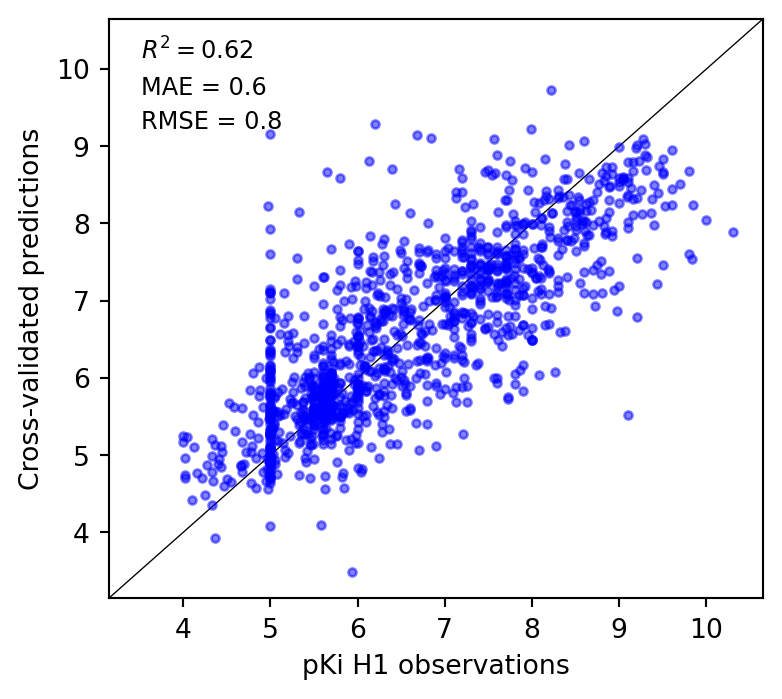

In [29]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="pKi H1 observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/rdkit/rdkit_H1.svg') 

## Muscarinic receptor pKi

In [30]:
df = pd.read_csv("./data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1145


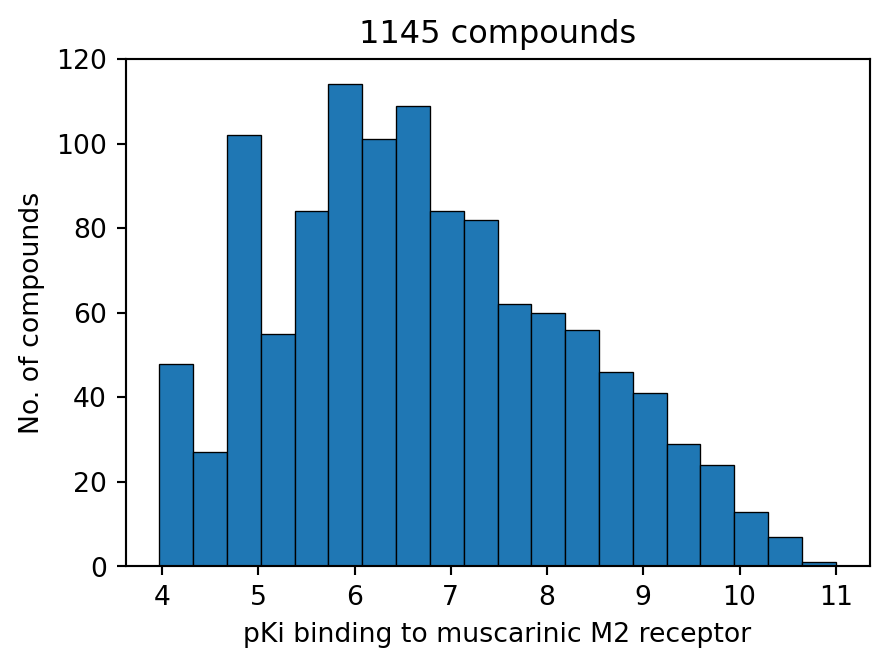

In [31]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [32]:
D, idx = smiles_to_descriptors(smiles)
Y = Y[idx]

In [33]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D.iloc[train_index, :], D.iloc[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    # Select those descriptors that we will use to train the model
    sfs.fit(D_train, y_train)
    print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}\n")
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
Features selected by forward sequential selection: ['FpDensityMorgan2', 'Chi3v', 'LabuteASA', 'PEOE_VSA5', 'PEOE_VSA8', 'SlogP_VSA3', 'SlogP_VSA8', 'EState_VSA7', 'fr_HOCCN', 'fr_amide', 'fr_aryl_methyl', 'fr_bicyclic', 'fr_ketone', 'fr_piperzine', 'fr_sulfone']

{'C': 500, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 2/10
Features selected by forward sequential selection: ['FpDensityMorgan1', 'FpDensityMorgan2', 'Chi3v', 'Chi4n', 'SMR_VSA3', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA8', 'EState_VSA3', 'VSA_EState2', 'FractionCSP3', 'fr_aryl_methyl', 'fr_ester', 'fr_halogen', 'fr_sulfonamd']

{'C': 50, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 3/10
Features selected by forward sequential selection: ['qed', 'FpDensityMorgan3', 'Chi3v', 'PEOE_VSA11', 'PEOE_VSA5', 'PEOE_VSA8', 'SlogP_VSA8', 'EState_VSA3', 'NumAliphaticCarbocycles', 'MolLogP', 'fr_amide', 'fr_aryl_methyl', 'fr_epoxide', 'fr_halogen', 'fr_sulfone']

{'C': 50, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 4/10
Features 

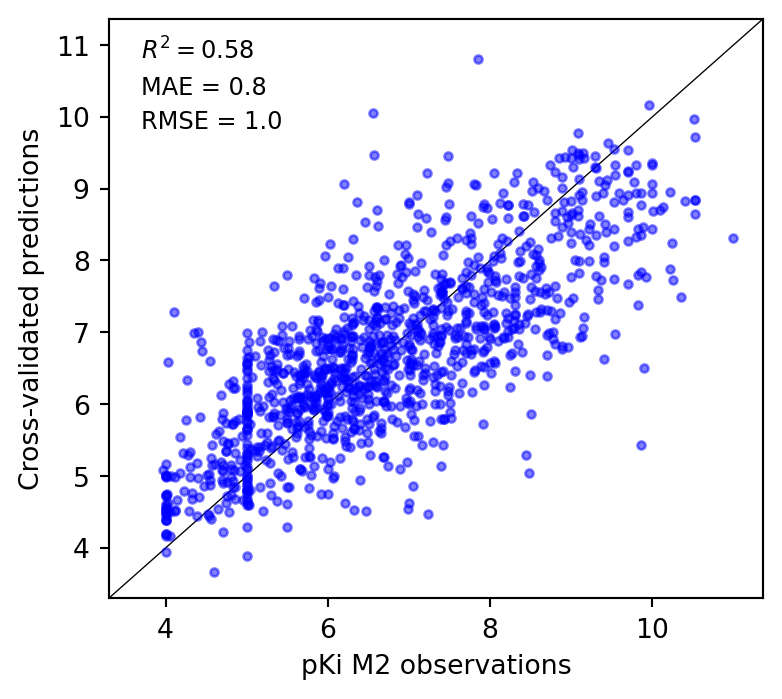

In [34]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="pKi M2 observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/rdkit/rdkit_M2.svg') 